PROJECT: SENTIMENT ANALYSIS
---
PRODUCT : An online browser
--
Author: Linh Le



In [1]:
# Install essential modules
# !pip install nltk
# !pip install --upgrade pip
# !pip install seaborn
# !pip install langdetect
# !pip install -U textblob
# !python -m textblob.download_corpora

In [128]:
# Import libraries
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
plt.style.use("ggplot")

TARGET 1: THE WHOLE DATASET (Both English and Non-english reviews included)
--
(1) To find the average review scores and have an overview of the dataset

In [2]:
# Read data to Python script
sql ="""
SELECT *
FROM `Table A` 
ORDER BY date
"""
df_whole = pd.read_gbq(sql, project_id='osp-bu-mobile') 
print("The number of all reviews : ", df_whole.shape)

NameError: name 'pd' is not defined

 The average OFA review scores from total reviews:  4.325852834740651


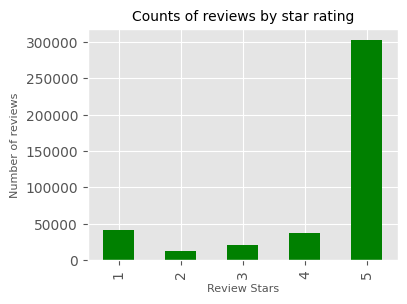

In [130]:
# Calculating the average review score of total reviews from 2020 to 2023 : 
avg_score = df_whole['starRating'].mean()
print(" The average review scores from total reviews: ",avg_score)      

# Counting the Star rating
%matplotlib inline
ax = df_whole['starRating'].value_counts().sort_index().plot(kind = "bar", 
                    figsize = (3,2), color = "grey")
ax.set_xlabel("Review Stars", fontsize = 8)
ax.set_ylabel("Number of reviews", fontsize = 8)
plt.title("Counts of reviews by star rating", fontsize = 10)
plt.show()

Overall, we get a quite high average review score of approximately 4.326

In [131]:
# Reading a new dataframe from datawarehouse with the monthly average reviews scores calculated
sql ="""
SELECT DATE_TRUNC(DATE(date),MONTH) as Month, AVG(starRating) as avg_total_reviews
FROM `Table A` 
GROUP BY 1
ORDER BY 1
"""
df_month = pd.read_gbq(sql, project_id='osp-bu-mobile') 

In [132]:
# The lowest score:
lowest_score = df_month.reset_index().sort_values(by ='avg_total_reviews').head(1)  #  3.840554
print(lowest_score)
# The highest score:
highest_score = df_month.reset_index().sort_values(by ='avg_total_reviews').tail(1)  # 4.451933
print(highest_score)

    index      Month  avg_total_reviews
12     12 2021-06-01           3.840554
   index      Month  avg_total_reviews
5      5 2020-11-01           4.451933


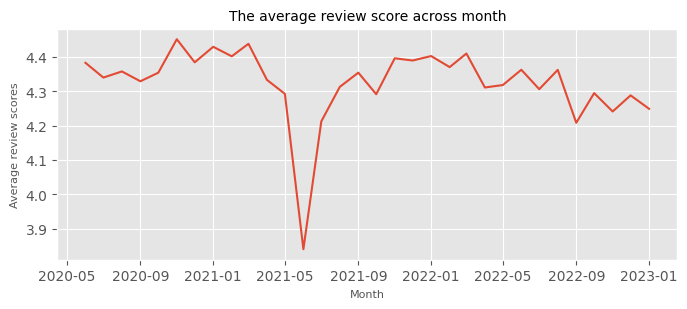

In [133]:
# Ploting the average review scores across months
%matplotlib inline

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(3)
plt.plot(df_month['Month'], df_month['avg_total_reviews'])
plt.xlabel('Month', fontsize = 8)
plt.ylabel('Average review scores', fontsize = 8)
plt.title("The average review score across month", fontsize = 10)
plt.show()

We see that the average review score fluctuates overtime and have a decreasing trend in recent months. Especially, it decreased 
dramatically in June 2021 (with score = 3.840554) => Let's see in details what was going on in this period.

Script for June 2021: 

TARGET 2: CONDUCTING NLP TO FIND OUT THE MOST COMMON FEATURES THAT ARE MENTIONED IN THE REVIEWS
--

(1) Find the top common features mentioned
(2) Calculate the attribution weight/review score of each common feature to the average review score 
(3) Examine the fluctuation of the average score of each common feature

NOTE: This time, we analyze English reviews only. However, there are many reviews written in English while the reviewerLanguage is different from English. Therefore, we will detect English reviews whose reviewerLanguage in the original data is different from English, then combine with english reviews of which reviewerLanguage is also english.

DATA PREPARATION
--

In [134]:
# Get the reviews with reviewerLanguage = "en" first for faster running in the non-english dataset
sql ="""
SELECT date, text, starRating, reviewerLanguage
FROM `Table A` 
WHERE reviewerLanguage IN ("en")
ORDER BY date
"""
df_eng = pd.read_gbq(sql, project_id='osp-bu-mobile')
print(df_eng.shape)

(118769, 4)


/usr/local/share/miniconda3/lib/python3.8/site-packages/google/cloud/bigquery/table.py:2014: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  df[column] = pandas.Series(df[column], dtype=dtypes[column])


In [135]:
# Get the english reviews with reviewerLanguage != "en" 
sql ="""
SELECT date, text, starRating, reviewerLanguage
FROM `Table A` 
WHERE reviewerLanguage NOT IN ("en")
ORDER BY date
"""
df_non = pd.read_gbq(sql, project_id='osp-bu-mobile')
print(df_non.shape)

(295731, 4)


/usr/local/share/miniconda3/lib/python3.8/site-packages/google/cloud/bigquery/table.py:2014: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  df[column] = pandas.Series(df[column], dtype=dtypes[column])


In [136]:
# Define a function to get all english reviews from df_non

def detect_english(text):
    try:
        detected_lang = detect(text)
        if detected_lang == 'en':
            return text
        else:
            return "None"
    except:
        detected_lang = "None"

In [137]:
# TEXT PROCESSING
# Remove numbers
def remove_number(text):
    clean_text = ''.join(filter(lambda x: not x.isdigit(), text))
    return clean_text

# Remove special character
import re
def remove_character(text):
    normal_string = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    return normal_string

# Remove emojis
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [138]:
# Apply removing fucntions to the dataframe
df_non["text"] = df_non["text"].apply(lambda x: remove_emojis(x))
df_non["text"] = df_non["text"].apply(lambda x: remove_number(x))
df_non["text"] = df_non["text"].apply(lambda x: remove_character(x))

In [139]:
# Apply detecting English review function to the dataframe (Note: this line of code takes quite a long time to run ~ 15 mins)
df_non["text"] = df_non["text"].apply(lambda x: detect_english(x))
print(" The original shape of df_non: ",df_non.shape)   

 The original shape of df_non:  (295731, 4)


In [140]:
# Only take the satisfying reviews
df_non = df_non[df_non['text'] != "None"]
print("The shape of df_non after removing non-english reviews: ", df_non.shape)

The shape of df_non after removing non-english reviews:  (181298, 4)


In [141]:
# Combine the two dataframe to get the final dataset
df = pd.concat([df_eng, df_non])
print(" The shape of df with all english reviews: ", df.shape) 

# Create an ID column for each review of the whole dataset
df['ID'] = df.index + 1
first_column = df.pop("ID")
df.insert(0, "ID", first_column)

 The shape of df with all english reviews:  (300067, 4)


Figure out the most common keywords/ topics
-----

STEP 1: TEXT PROCESSING

In [16]:
# Install packages
# !pip install wordcloud
# !pip install -U textblob
# !python -m textblob.download_corpora

In [142]:
# Importing libraries
import os
from os import path
from wordcloud import WordCloud, STOPWORDS
# from nltk.probability import FreDist
from nltk.corpus import stopwords
nltk.download('stopwords')
from textblob import TextBlob
from textblob import Word

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [143]:
# Convert all the text to lower strings
df['text'] = df['text'].str.lower()

# Tokenization
df['text'].apply(lambda x: TextBlob(str(x)).words).head()  # This line of code kinda takes time

# Lemmatization: to break down the word to its root
df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in str(x).split()]))

# Removing stopwords
stop_words = stopwords.words("english") # 179 stopwords for english
df['text'] = df['text'].apply(lambda x : " ".join(x for x in str(x).split() if x not in stop_words))

# Removing rarewords
# drop = pd.Series(' '.join(df['text']).split())  # Take a df column first, then join to make it a list, then use split() because split() could not be used for tuple
# drop = drop.value_counts()[-24000:] # drop words apprearing 4 times and less than 4 times
# df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in drop))
# df['text']

In [144]:
# Taking the dataframe containing top common features for the later user
vpn_text = df[df['text'].str.contains("vpn")]
ad_text = df[df['text'].str.contains("ad|advertising|blocker|block|blocking|advertisement|advert")]
page_text = df[df['text'].str.contains("page")]
search_text = df[df['text'].str.contains("search")]
version_text = df[df['text'].str.contains("version|update")]
speed_text = df[df['text'].str.contains("speed")]

speed_dial = speed_text[speed_text['text'].str.contains("dial")]

In [70]:
vpn_text.head(5)

,ID,date,text,starRating,reviewerLanguage
3,4,2020-06-22 11:34:10+00:00,vpn doe work,1,en
15,16,2020-06-22 13:01:04+00:00,it’s vpn system doesn’t connect. always show c...,1,en
19,20,2020-06-22 13:30:28+00:00,"last update vpn working, say connecting nothin...",1,en
29,30,2020-06-22 15:23:50+00:00,"shame built-in vpn work anymore. otherwise, wa...",2,en
30,31,2020-06-22 15:40:39+00:00,love vpn,5,en


In [145]:
# Define a function to get nouns only from the reviews
def nouns_only(sentence):
    noun_tag = ['NN','NNP','NNS','NNPS']
    tokens = nltk.word_tokenize(sentence)
    tag = nltk.pos_tag(tokens)
    word_list = [word for word,pos in tag if (pos in noun_tag) if(word not in ['browser','app','application','thank','work','use'])]
    return ' '.join(word_list)

# Apply the nouns_only functions to all the text in the dataframe
df['text'] = df['text'].apply(lambda x : nouns_only(x))    # Note: this line of code takes a bit long time to run


STEP 2: TERM FREQUENCY & TEXT VISUALIZATION

In [146]:
# Counting the term frequency to figure out the most common features mentioned in the reviews

TF = df["text"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index() # Note: this line of code takes ~ 25 mins
TF.columns = ["Word", "TF"]

# Sorting to get the most common words
TF = TF.sort_values(by = "TF", ascending = False)
# TF.head(50)

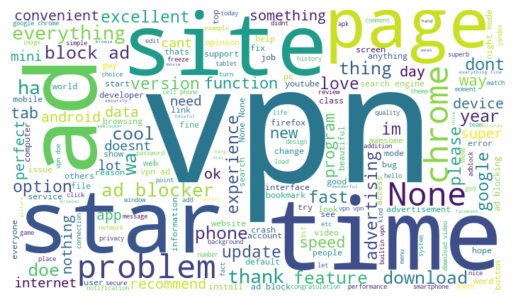

In [147]:
# Create the wordcloud to visualize the text
%matplotlib inline
word = " ".join(i for i in df['text'])
wordcloud = WordCloud(width = 700, height = 400,
                        background_color = "white").generate(word)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

TOP commonly mentioned features in the reviews:
---
1. Ad
2. VPN
3. Page
4. Search
5. Version/Update
6. Speed    

Measuring the weight attribution of top features to the average score of the product

In [148]:
# Average review score of in general
print("The average review scores: ", df['starRating'].mean())

# (1) Average score of VPN
df_vpn = df[df['text'].str.contains("vpn")]
score_vpn = df_vpn['starRating'].mean()
print("The average review scores of VPN: ", score_vpn)

# (2) Average score of Ad(blocking)
df_ad = df[df['text'].str.contains("ad|advertising|blocker|block|advertisement|adverts|adblocker")]
score_ad =  df_ad['starRating'].mean()
print("The average review scores of Ad blocking: ",score_ad)

# (3) Average score of Page load
df_page = df[df['text'].str.contains("page")]
score_page = df_page['starRating'].mean()
print("The average review scores of Page load: ", score_page)

# (4) Average score of Search engine
df_search = df[df['text'].str.contains("search")]
score_search = df_search['starRating'].mean()
print("The average review scores of Search engine: ", score_search)

# (5) Average score of Version
df_version = df[df['text'].str.contains("version|update")]
score_version = df_version['starRating'].mean()
print("The average review scores of Version: ", score_version)

# (6) Average score of Speed
df_speed = df[df['text'].str.contains("speed")]
score_speed = df_speed['starRating'].mean()
print("The average review scores of Speed: ", score_speed)

# Score attribution of top 3 features to the average review scores:
obs_of_reviews = (len(df_vpn) + len(df_ad) + len(df_page)) + len(df_search) + len(df_version) + len(df_speed)

vpn_score_attribution = score_vpn*len(df_vpn)/obs_of_reviews
ad_score_attribution = score_ad*len(df_ad)/obs_of_reviews
page_score_attribution = score_page*len(df_page)/obs_of_reviews
search_score_attribution = score_search*len(df_search)/obs_of_reviews
version_score_attribution = score_version*len(df_version)/obs_of_reviews
speed_score_attribution = score_speed*len(df_speed)/obs_of_reviews

score_attribution = vpn_score_attribution + ad_score_attribution + page_score_attribution + search_score_attribution + version_score_attribution + speed_score_attribution
print("The score attribution of top 4 common features to the average score: ", score_attribution)


The average OFA review scores:  4.215058636904424
The average review scores of VPN:  3.3623747108712414
The average review scores of Ad blocking:  3.705148595837499
The average review scores of Page load:  3.11153889706715
The average review scores of Search engine:  3.5631735840403578
The average review scores of Version:  3.1762061732094695
The average review scores of Speed:  3.7520520803849418
The score attribution of top 4 common features to the average OFA score:  3.52966556191624


Conclusion:
--
Reviews mentioning Page load gives the lowest review score, followed by reviews about Version/Update and then VPN. In addition, the score attributed by the top commonn features is not close to overall score, meaning these top common features do not properly explain the overall review score.

Plotting chart to see the fluctuation of monthly average scores of top common features - regardless of languages
--

In [149]:
# Reading a new dataframe from SQL with the monthly average reviews scores calculated - total review regardless of languages
sql = f"""
WITH
total AS (
SELECT DATE_TRUNC(DATE(date),MONTH) AS Month,AVG(starRating) AS starRating
FROM `Table A`
GROUP BY month ),

ad as (
SELECT DATE_TRUNC(DATE(date),MONTH) as Month, AVG(starRating) AS starRating
FROM `Table A` 
WHERE 
  LOWER(text) LIKE "ad%"
  OR LOWER(text) LIKE "%advertising%"
  OR LOWER(text) LIKE "%block%"
  OR LOWER(text) LIKE "%blocker%"
  OR LOWER(text) LIKE "%blocking%"
GROUP BY month),

vpn AS (
SELECT DATE_TRUNC(DATE(date),MONTH) AS Month, AVG(starRating) AS starRating
FROM `Table A`
WHERE LOWER(text) LIKE "%vpn%"
GROUP BY month),

page AS (
SELECT DATE_TRUNC(DATE(date),MONTH) AS Month, AVG(starRating) AS starRating
FROM `Table A`
WHERE LOWER(text) LIKE "%page%"
GROUP BY month),

search_engine AS (
SELECT DATE_TRUNC(DATE(date),MONTH) AS Month, AVG(starRating) AS starRating
FROM `Table A`
WHERE LOWER(text) LIKE "%search%"
GROUP BY month),

version AS (
SELECT DATE_TRUNC(DATE(date),MONTH) AS Month, AVG(starRating) AS starRating
FROM `Table A`
WHERE 
    (LOWER(text) LIKE "%version%"
    OR LOWER(text) LIKE "%update%")
GROUP BY month),

speed AS (
SELECT DATE_TRUNC(DATE(date),MONTH) AS Month, AVG(starRating) AS starRating
FROM `Table A`
WHERE LOWER(text) LIKE "%speed%"
GROUP BY month)


SELECT total.Month, total.starRating as overall_score, ad.starRating as adblocker, vpn.starRating as vpn, page.starRating as page, search_engine.starRating as search_engine, version.starRating as version, speed.starRating as speed
FROM total
LEFT JOIN ad USING(Month)
LEFT JOIN vpn USING(Month)
LEFT JOIN page USING(Month)
LEFT JOIN search_engine USING(Month)
LEFT JOIN version USING(Month)
LEFT JOIN speed USING(Month)
ORDER BY 1
"""
df_monthly = pd.read_gbq(sql, project_id='osp-bu-mobile') 

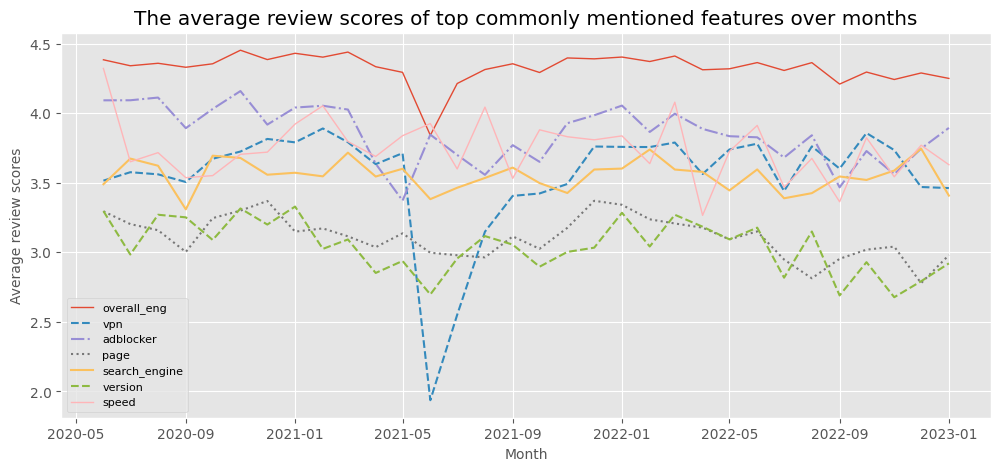

In [179]:
# Ploting the average review scores across months of top common features
%matplotlib inline

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(5)

plt.plot(df_monthly['Month'], df_monthly['overall_score'], label = 'overall_eng', linestyle = "-", linewidth = 1)
plt.plot(df_monthly['Month'], df_monthly['vpn'], label = 'vpn', linestyle = "--")
plt.plot(df_monthly['Month'], df_monthly['adblocker'], label = 'adblocker', linestyle = "-.")
plt.plot(df_monthly['Month'], df_monthly['page'], label = 'page', linestyle = ":", linewidth = 1.5)
plt.plot(df_monthly['Month'], df_monthly['search_engine'], label = 'search_engine', linestyle = "-")
plt.plot(df_monthly['Month'], df_monthly['version'], label = 'version', linestyle = "--")
plt.plot(df_monthly['Month'], df_monthly['speed'], label = 'speed', linestyle = "-", linewidth = 1)

plt.legend(fontsize = 8)
plt.xlabel('Month', fontsize = 10)
plt.ylabel('Average review scores', fontsize = 10)
plt.title ("The average review scores of top commonly mentioned features over months")
plt.show()


Running a multiple regression model to find the correlation between the scores of top common features and overall review score
--

In [152]:
#  Import packages
from sklearn.linear_model import LinearRegression

# Specify a LinearRegresison model
model = LinearRegression()

# Getting dependent variables = overall_score
y = df_monthly['overall_score'].values.reshape(len(df_monthly),1)
x = df_monthly[['vpn','adblocker','page','search_engine','version','speed']]

# Running the regression model
model_fit = model.fit(x,y)

# Getting R-squared
r_square = model_fit.score(x,y)
print("R-squared : ", r_square)
print("CONCLUSION: Top 6 common features explain approximately 85 percent of the variation of the overall_score")
print("Intercept :", model.intercept_)
print("Slope coefficients : ", model.coef_)

R-squared :  0.8317330815891395
CONCLUSION: Top 6 common features explain approximately 85 percent of the variation of the OFA overall_score
Intercept : [2.6018735]
Slope coefficients :  [[ 0.17549908  0.01492969 -0.03201769  0.10631359  0.23806442  0.01086798]]


# Below 
are the sentiment analyses for the NEGATIVE reviews talking about top common features. However, the followings basically give the ideas about how good or bad the reviews is talking about the product by sorting the most commonly used adjectives. From that, I manually have a look at the sorted reviews to more correctly reflect the content of the reviews. The results are drawn after taking these two steps.

In [153]:
# DEFINE A FUNCTION TO GET ADJECTIVES ONLY IN THE REVIEWS

def adj_only(sentence):
    adj_tags = ["JJ","JJR","JJS"]
    tokens = nltk.word_tokenize(sentence)
    tag = nltk.pos_tag(tokens)
    word_list = [word for word,pos in tag if (pos in adj_tags) if(word not in ['update','speed','download','dial','website','internet','great','web','vpn','browser','app','good','many','best',"open",'application','good','free','great','better','best','many','ad''update','new','last','much','page','mobile','top','main','full'])]
    return ' '.join(word_list)

# Sentiment analysis with text containing "VPN"
Result: Most negative reviews about VPN complaining that 

- VPN does not work at all
- VPN only works for certain pages while most pages do not load when VPN is turned on
- Free VPN is not really free because the browser asks PRO version of VPN for a proper VPN mode.
- Users do not really trust the privacy and security of free VPN

For recent reviews, since late 2022 up to now, many users still complain that VPN does not work at all. And many reviews showing that the reason they install the browser is because of VPN and uninstall the app also due to VPN not working too.

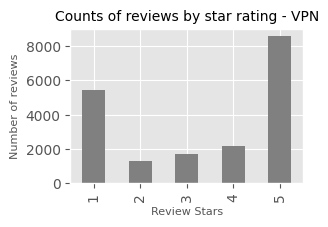

In [157]:
# Counting the Star rating
%matplotlib inline
ax1 = vpn_text['starRating'].value_counts().sort_index().plot(kind = "bar", 
                    figsize = (3,2), color = "grey")
ax1.set_xlabel("Review Stars", fontsize = 8)
ax1.set_ylabel("Number of reviews", fontsize = 8)

plt.title("Counts of reviews by star rating - VPN", fontsize = 10)
plt.show()

/tmp/ipykernel_617/3849565098.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_vpn['text'] = neg_vpn['text'].apply(lambda x : adj_only(x))


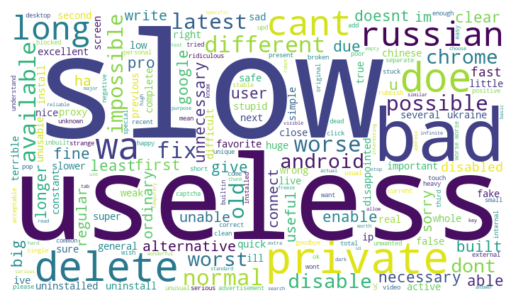

In [158]:
# Taking only negative reviews with starRating of 1 and 2
neg_vpn = vpn_text[(vpn_text['starRating'] == 1) | (vpn_text['starRating'] == 2)] 

# Apply keeping adjective only function to all NEGATIVE reviews about page load
neg_vpn['text'] = neg_vpn['text'].apply(lambda x : adj_only(x))

# Count the term frequency
TF = neg_vpn["text"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
TF.columns = ["Word", "TF"]

TF = TF.sort_values(by = "TF", ascending = False)
# TF.head(5)

# Create the wordcloud
%matplotlib inline
word = " ".join(i for i in neg_vpn['text'])
wordcloud = WordCloud(width = 700, height = 400,
                        background_color = "white",
                        ).generate(word)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


# Sentiment analysis with text containing "Page"
RESULT:
- Page loads very slowly
- For recent reviews since 2022, most complains saying that the latest update has the app crashed when opening a page, specifically the page appears white and no data. It also impossible to scroll the page, specifically only the background of the page remains while the images and words all disappear when users scroll the page.

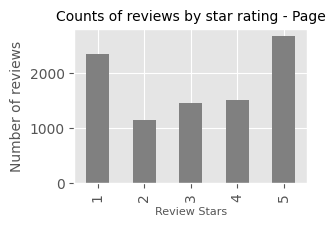

In [159]:
# Counting the Star rating
%matplotlib inline

ax = page_text['starRating'].value_counts().sort_index().plot(kind = "bar",           
          figsize = (3,2), color = "grey")
ax.set_xlabel("Review Stars", fontsize = 8)
ax.set_ylabel("Number of reviews", fontsize = 10)
plt.title("Counts of reviews by star rating - Page", fontsize = 10)
plt.show()

/tmp/ipykernel_617/4160769786.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_page['text'] = neg_page['text'].apply(lambda x : adj_only(x))


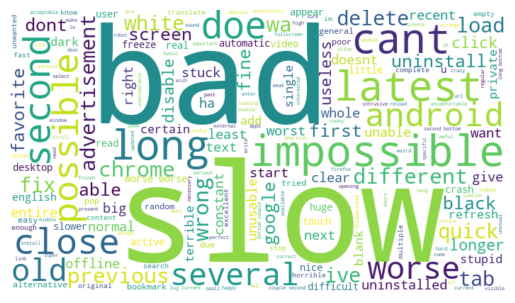

In [160]:
# Taking only negative reviews with starRating of 1 and 2
neg_page = page_text[(page_text['starRating'] == 1) | (page_text['starRating'] == 2)] 

# Apply keeping adjective only function to all NEGATIVE reviews about page load
neg_page['text'] = neg_page['text'].apply(lambda x : adj_only(x))

# Count the term frequency
TF = neg_page["text"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
TF.columns = ["Word", "TF"]

TF = TF.sort_values(by = "TF", ascending = False)
# TF.head(5)

# Create the wordcloud
%matplotlib inline
word = " ".join(i for i in neg_page['text'])
wordcloud = WordCloud(width = 700, height = 400,
                        background_color = "white",
                        ).generate(word)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


# Sentiment analysis with text talking about DOWNLOAD SPEED
RESULT:
- Download speed is (very) slow and it is worse when VPN is on

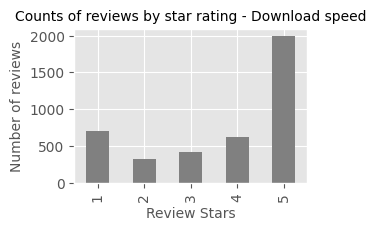

In [161]:
# Counting the Star rating
%matplotlib inline

ax = speed_text['starRating'].value_counts().sort_index().plot(kind = "bar",           
          figsize = (3,2), color = "grey")
ax.set_xlabel("Review Stars", fontsize = 10)
ax.set_ylabel("Number of reviews", fontsize = 10)
plt.title("Counts of reviews by star rating - Download speed", fontsize = 10)
plt.show()

/tmp/ipykernel_617/3821235424.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_speed['text'] = neg_speed['text'].apply(lambda x : adj_only(x))


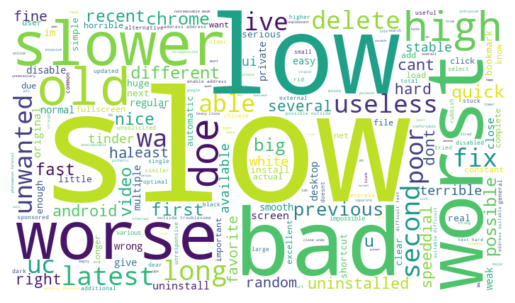

In [162]:
# Taking only negative reviews with starRating of 1 and 2
neg_speed = speed_text[(speed_text['starRating'] == 1) | (speed_text['starRating'] == 2)] 

# Apply keeping adjective only to all NEGATIVE reviews about downloading speed
neg_speed['text'] = neg_speed['text'].apply(lambda x : adj_only(x))

# Count the term frequency
TF = neg_speed["text"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
TF.columns = ["Word", "TF"]

TF = TF.sort_values(by = "TF", ascending = False)
TF.head(5)

# Create the wordcloud
%matplotlib inline
word = " ".join(i for i in neg_speed['text'])
wordcloud = WordCloud(width = 700, height = 400,
                        background_color = "white",
                        ).generate(word)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


# Sentiment analysis with text talking about SPEED DIAL
RESULT:
- Most of negative reviews say that users are annoyed at having unwanted/strange sites/advertisements automatically added to their Speed Dial without permission.
- Interesting fact: Many reviews mention that they have Tinder automatically added to their Speed Dial, causing kinda troubles for them

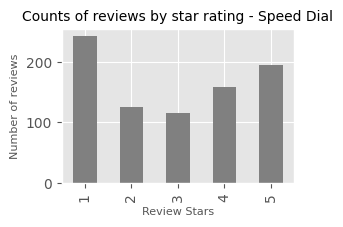

In [163]:
# Counting the Star rating
%matplotlib inline

ax = speed_dial['starRating'].value_counts().sort_index().plot(kind = "bar", 
          title = "Counts of reviews by star rating - Speed Dial", 
          figsize = (3,2), color = "grey")
ax.set_xlabel("Review Stars", fontsize = 8)
ax.set_ylabel("Number of reviews", fontsize = 8)
plt.title("Counts of reviews by star rating - Speed Dial", fontsize = 10)
plt.show()

/tmp/ipykernel_617/625981652.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_speed_dial['text'] = neg_speed_dial['text'].apply(lambda x : adj_only(x))


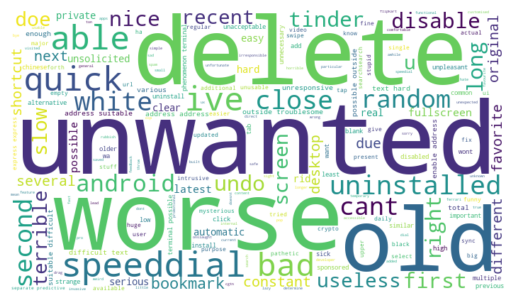

In [164]:
# Taking only negative reviews with starRating of 1 and 2
neg_speed_dial = speed_dial[(speed_dial['starRating'] == 1) | (speed_dial['starRating'] == 2)] 

# Apply keeping adjective only to all NEGATIVE reviews about downloading speed
neg_speed_dial['text'] = neg_speed_dial['text'].apply(lambda x : adj_only(x))

# Count the term frequency
TF = neg_speed_dial["text"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
TF.columns = ["Word", "TF"]

TF = TF.sort_values(by = "TF", ascending = False)
TF.head(5)

# Create the wordcloud
%matplotlib inline
word = " ".join(i for i in neg_speed_dial['text'])
wordcloud = WordCloud(width = 700, height = 400,
                        background_color = "white",
                        ).generate(word)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Sentiment analysis with text talking about Search Engine
RESULT:
- Most negative reviews complain that the app does not support switching to the desired default search engine


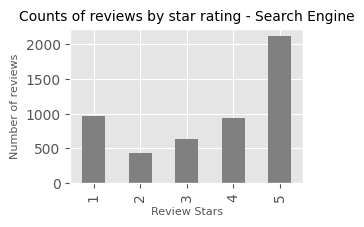

In [165]:
# Counting the Star rating
%matplotlib inline

ax = search_text['starRating'].value_counts().sort_index().plot(kind = "bar", 
          title = "Counts of reviews by star rating - Speed Dial", 
          figsize = (3,2), color = "grey")
ax.set_xlabel("Review Stars", fontsize = 8)
ax.set_ylabel("Number of reviews", fontsize = 8)
plt.title("Counts of reviews by star rating - Search Engine", fontsize = 10)
plt.show()

/tmp/ipykernel_617/782228681.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_search['text'] = neg_search['text'].apply(lambda x : adj_only(x))


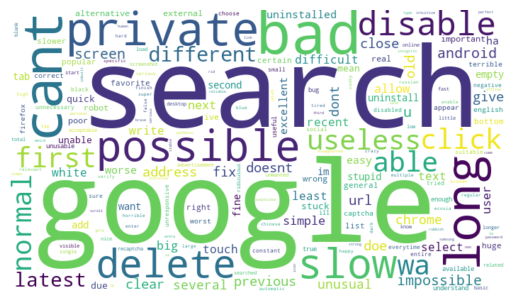

In [166]:
# Taking only negative reviews with starRating of 1 and 2
neg_search = search_text[(search_text['starRating'] == 1) | (search_text['starRating'] == 2)] 

# Apply keeping adjective only to all NEGATIVE reviews about downloading speed
neg_search['text'] = neg_search['text'].apply(lambda x : adj_only(x))

# Count the term frequency
TF = neg_search["text"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
TF.columns = ["Word", "TF"]

TF = TF.sort_values(by = "TF", ascending = False)
TF.head(5)

# Create the wordcloud
%matplotlib inline
word = " ".join(i for i in neg_search['text'])
wordcloud = WordCloud(width = 700, height = 400,
                        background_color = "white",
                        ).generate(word)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


# Sentiment analysis with text talking about Version/ Update
RESULT: 
- There is a considerable drop in review score regarding the version feature in June 2021. Accordingly, most of reviews say that the latest update/version is bad/horrible/terrible due to the following reasons:
    - The app/browser freezes when (1) watching videos, (2) closing tabs
    - There are so many ads in the latest version
    - Higher battery consumption
    - The interface is broken
    - All saved files before the updates are missing
    - VPN still does not work properly with the updated version
    
- Most users prefer the previous version, but there is no available old version to be downloaded.
    

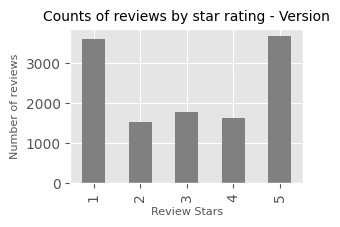

In [167]:
# Counting the Star rating
%matplotlib inline

ax = version_text['starRating'].value_counts().sort_index().plot(kind = "bar", 
                   figsize = (3,2), color = "grey")
ax.set_xlabel("Review Stars", fontsize = 8)
ax.set_ylabel("Number of reviews", fontsize = 8)
plt.title("Counts of reviews by star rating - Version", fontsize = 10)
plt.show()

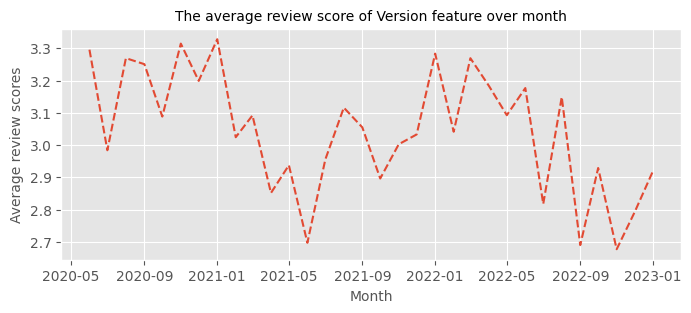

In [168]:
# Ploting the average review scores across months
%matplotlib inline

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(3)

plt.plot(df_monthly['Month'], df_monthly['version'], label = 'version', linestyle = "--")

plt.xlabel('Month', fontsize = 10)
plt.ylabel('Average review scores', fontsize = 10)
plt.title("The average review score of Version feature over month", fontsize = 10)
plt.show()

/tmp/ipykernel_617/884650363.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_version['text'] = neg_version['text'].apply(lambda x : adj_only(x))


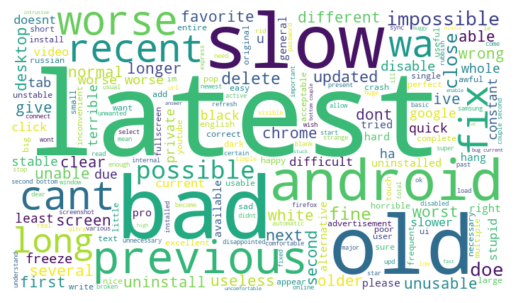

In [169]:
# Taking only negative reviews with starRating of 1 and 2
neg_version = version_text[(version_text['starRating'] == 1) | (version_text['starRating'] == 2)] 

# Apply keeping adjective only to all NEGATIVE reviews about downloading speed
neg_version['text'] = neg_version['text'].apply(lambda x : adj_only(x))

# Count the term frequency
TF = neg_version["text"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
TF.columns = ["Word", "TF"]

TF = TF.sort_values(by = "TF", ascending = False)
TF.head(5)

# Create the wordcloud
%matplotlib inline
word = " ".join(i for i in neg_version['text'])
wordcloud = WordCloud(width = 700, height = 400,
                        background_color = "white",
                        ).generate(word)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


The above wordcloud shows that the most common words are "old", "latest", and "previous". This is what is happening in the reviews in which users compare the old/previous version and the latest version and they prefer the old/previous version to the latest one as pointed above.

# Sentiment analysis with text talking about Adblocker
Result: Most negative reviews say that
- Adblocker function does not work at all
- Adblocker used to work well. but now there are so many advertising and pop-up appearing when using browser

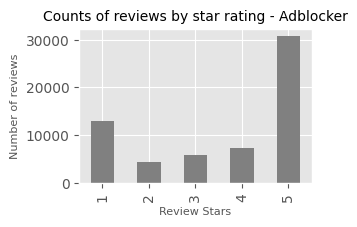

In [170]:
# Counting the Star rating
%matplotlib inline

ax = ad_text['starRating'].value_counts().sort_index().plot(kind = "bar", 
                    figsize = (3,2), color = "grey")
ax.set_xlabel("Review Stars", fontsize = 8)
ax.set_ylabel("Number of reviews", fontsize = 8)
plt.title("Counts of reviews by star rating - Adblocker", fontsize = 10)
plt.show()

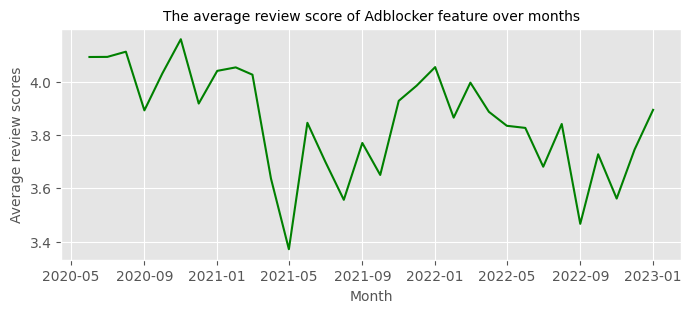

In [173]:
# Ploting the average review scores across months
%matplotlib inline

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(3)

plt.plot(df_monthly['Month'], df_monthly['adblocker'], label = 'adblocker', linestyle = "-", color = "green")

plt.xlabel('Month', fontsize = 10)
plt.ylabel('Average review scores', fontsize = 10)
plt.title("The average review score of Adblocker feature over months", fontsize = 10)
plt.show()

/tmp/ipykernel_617/367214588.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_ad['text'] = neg_ad['text'].apply(lambda x : adj_only(x))


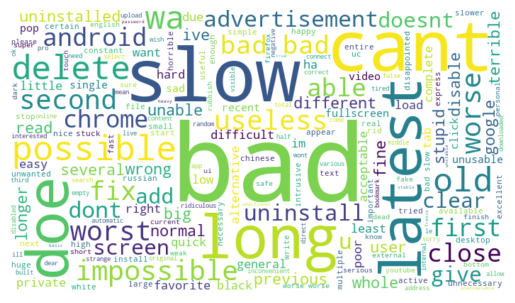

In [172]:
# Taking only negative reviews with starRating of 1 and 2
neg_ad = ad_text[(ad_text['starRating'] == 1) | (ad_text['starRating'] == 2)] 

# Apply keeping adjective only to all NEGATIVE reviews about downloading speed
neg_ad['text'] = neg_ad['text'].apply(lambda x : adj_only(x))

# Count the term frequency
TF = neg_ad["text"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
TF.columns = ["Word", "TF"]

TF = TF.sort_values(by = "TF", ascending = False)
TF.head(5)

# Create the wordcloud
%matplotlib inline
word = " ".join(i for i in neg_ad['text'])
wordcloud = WordCloud(width = 700, height = 400,
                        background_color = "white",
                        ).generate(word)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


# In conclusion: 
In general, the browser has a quite high average review score. When we break down the top commonly mentioned features, we still have good review scores for each feature. However, there are also so many negative reviews talking about these common features as showed above. This means the product does not really perform properly for all devices. 